In [1]:
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

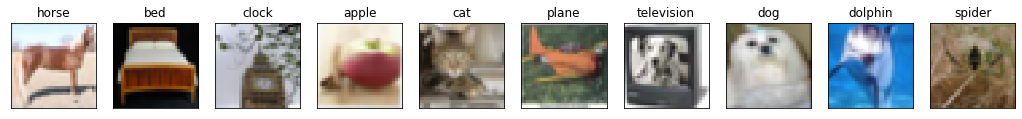

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

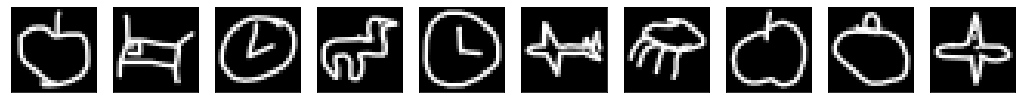

In [3]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

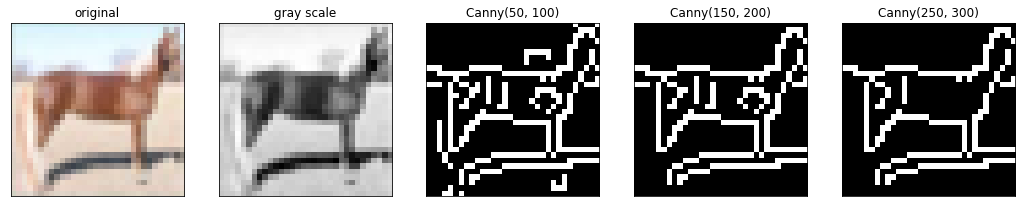

In [6]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 170, 260)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')

# Data Processing

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 260)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

In [9]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x
    
    

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c
    
#     def __init__(self, input_size=512, num_classes=10):
#         super(LabelPredictor, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.ReLU(inplace=True),
#             nn.Linear(256, num_classes),
#         )
        
#     def forward(self, h):
#         c = self.layer(h)
#         return c
    
    

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y
    
#     def __init__(self, input_size=512, num_classes=1):
#         super(DomainClassifier, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, num_classes),
#             nn.Sigmoid(),
#         )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [10]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [11]:
feature_extractor.load_state_dict(torch.load('extractor_model_8.bin'))
label_predictor.load_state_dict(torch.load('predictor_model_8.bin'))

<All keys matched successfully>

# Train
lambda

In [12]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [13]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# train
max_epoch = 10000

train_D_loss_col, train_F_loss_col, train_acc_col, lamb_curve = [],[],[],[]

for epoch in range(max_epoch):
    # You should chooose lamnda cleverly.
    lamb = get_lambda(epoch,max_epoch)
    lamb_curve.append(lamb)
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=get_lambda(epoch,max_epoch)) #get_lambda(epoch,max_epoch)

    train_D_loss_col.append(train_D_loss)
    train_F_loss_col.append(train_F_loss)
    train_acc_col.append(train_acc)
    
    torch.save(feature_extractor.state_dict(), f'extractor_model_9.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model_9.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc), end='\r')

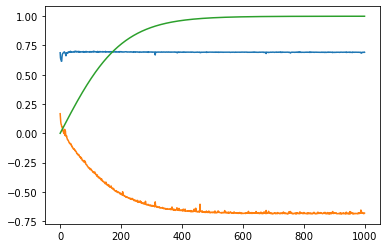

In [14]:
x = [i for i in range(max_epoch)]
plt.plot(x, train_D_loss_col)
plt.plot(x, train_F_loss_col)
plt.plot(x, lamb_curve)
plt.show()


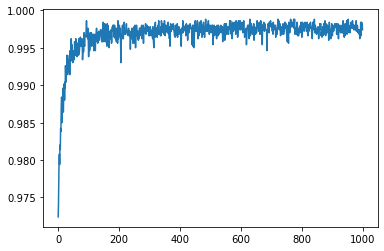

In [15]:
plt.plot(x, train_acc_col)
plt.show()

# Inference

In [16]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission_9.csv',index=False)

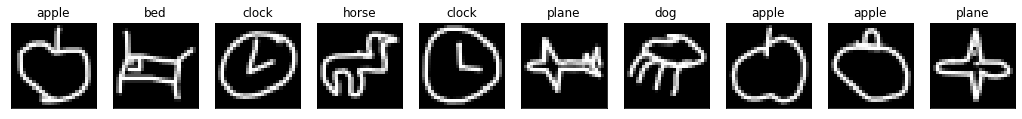

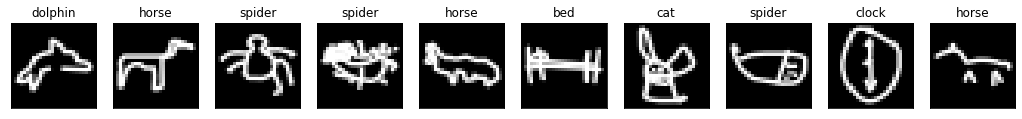

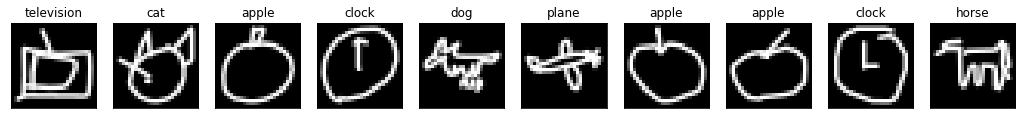

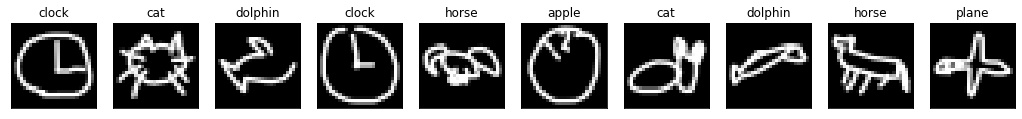

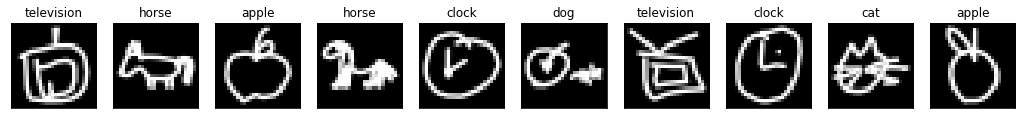

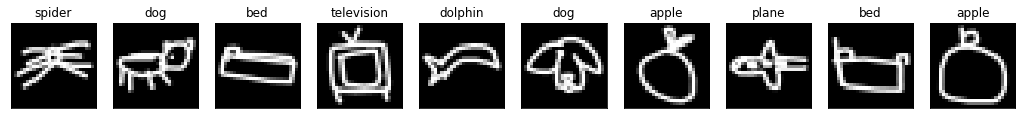

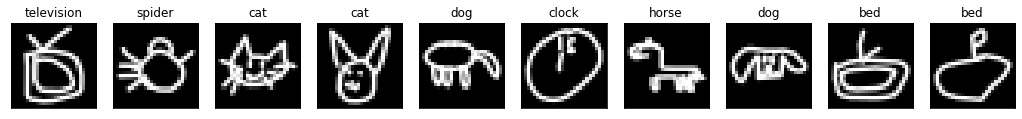

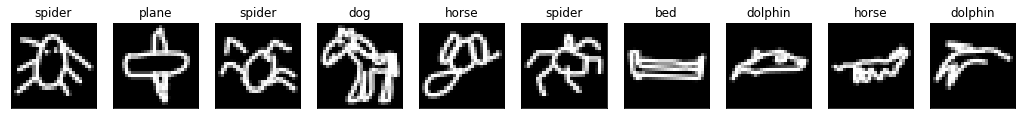

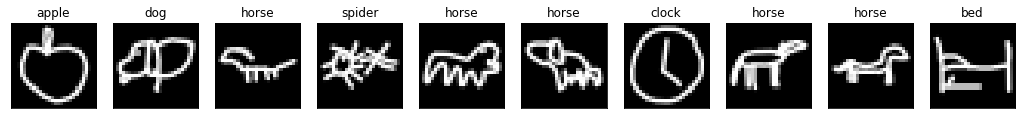

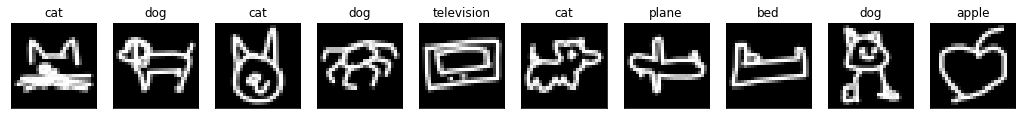

In [17]:
labels = iter(df['label'][:100])
def f_names():
    for i in range(100):
        yield ('real_or_drawing/test_data/0/{:05}.bmp'.format(i))

names = iter(f_names())


for j in range(10):
    plt.figure(figsize=(18, 18))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        name = next(names)
        label = next(labels)
        fig = no_axis_show(plt.imread(name),title=titles[label])

lambda https://github.com/Yangyangii/DANN-pytorch/blob/master/DANN.ipynb

ref https://blog.csdn.net/weixin_44673043/article/details/114858094

ref https://www.twblogs.net/a/5e92c454bd9eee34b83ea1cb